### Description:
 This script is a flattened version of the T-maze_Generalized.ipynb from Part 2 of the biaslab/LAIF github repository
 
### Purpose:
This script is for experimentation as well as for relieving the frustrations of having no easy ability to:
    
- ensure everything is available, as the original script pulls from a large handful of other files, each of which contain necessary code segments all of which you would have to modify individually if, say, you wanted to modify some aspect of the agent
- bypass malfunctional Manifest.toml and Project.toml loading
- keep package installations as minimal as possible -- enough are already required just to run this single agent simulation

### Instructions:
1. Install all packages under markdown "Packages to install once" only once. You will never have to install them again. You must un-comment and then execute the cell. It is strongly advised you comment them again after installation to avoid re-execution and potential inconsistencies.
2. Run all of the cells under the markdown "Flattened code". This will load *everything* that the original repository has siloed in various files/locations and pulls in using `include("file_name.jl")`. This is done easily by keeping the "Flattened code" section collapsed and clicking the "play" button next to "6 cells hidden ..."
3. The cells under markdown "Main Script" contain all of the code from the original notebook, with slight modifications, e.g., displaying the plots within the notebook rather than only saving them locally as .png files.

## Packages to install once

In [2]:
# # run all once
# using Pkg
# Pkg.add(["RxInfer", "LinearAlgebra", "Plots"])
# Pkg.add("DomainSets")
# Pkg.add("ForwardDiff")
# Pkg.add("ReactiveMP")
# Pkg.add("StatsFuns")
# Pkg.add("BayesBase")
# Pkg.add("LoopVectorization")
# Pkg.add("Distributions")
# Pkg.add("ExponentialFamily")
# Pkg.add("TupleTools")
# Pkg.add("LaTeXStrings")

    Updating registry at `C:\Users\andre\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\andre\.cursor-tutor-2\julia_actinf_pomdp\Project.toml`
  [37e2e46d] + LinearAlgebra
    Updating `C:\Users\andre\.cursor-tutor-2\julia_actinf_pomdp\Manifest.toml`
  [8e850b90] ↑ libblastrampoline_jll v5.8.0+1 ⇒ v5.11.0+0
Precompiling project...
  ✓ SoftGlobalScope
  ✓ IteratorInterfaceExtensions
  ✓ DataValueInterfaces
  ✓ RealDot
  ✓ Observables
  ✓ FunctionWrappers
  ✓ InitialValues
  ✓ InvertedIndices
  ✓ ContextVariablesX
  ✓ PrettyPrint
  ✓ ChainRulesCore
  ✓ ShiftedArrays
  ✓ ProgressLogging
  ✓ UnsafeAtomics
  ✓ InlineStrings
  ✓ FilePathsBase
  ✓ DefineSingletons
  ✓ WorkerUtilities
  ✓ ArgCheck
  ✓ Ratios
  ✓ AbstractFFTs
  ✓ Functors
  ✓ CEnum
  ✓ PooledArrays
  ✓ StableRNGs
  ✓ ShowCases
  ✓ VersionParsing
  ✓ Crayons
  ✓ CompositionsBase
  ✓ MPIPreferences
  ✓ SparseInverseSubset
  ✓ WoodburyMatrices
  ✓ SentinelArrays
  ✓ libsodium_jll
  ✓ Basele

## Flattened code

#### Perplexity response 10/19/2024
- https://www.perplexity.ai/search/describe-what-this-julia-code-1ktFES_MT3msisX0jmgxAQ (attached LAIF Part 2 pdf):


### distributions .jl

#### Perplexity:

This Julia code defines several custom probability distributions and related functions for use in a probabilistic modeling framework, likely for implementing the Lagrangian Active Inference (LAIF) algorithm described in the attached paper. Here's a breakdown of the main components:

1. ContinuousMatrixvariateLogPdf: A custom distribution for matrix-variate probability density functions.
    - Applications of matrix-variate PDFs include:
        - Multivariate Statistics: For modeling covariance structures in high-dimensional data.
        - Signal Processing: In array signal processing and multi-channel time series analysis.
        - Structural Dynamics: To quantify uncertainty in mass, stiffness, and damping matrices in linear structural dynamics4.
        - Machine Learning: In Bayesian approaches to neural networks and other matrix-based models.

2. SampleList: Extensions for handling lists of samples, including a function to compute the mean and entropy (h) of the samples.

3. MatrixDirichlet: A matrix-variate extension of the Dirichlet distribution, including methods for logpdf calculation, random sampling, and computing mean and entropy.

4. Transition: Custom message passing rules for a transition node in a factor graph, likely used in the T-maze experiment described in the paper.

Key aspects of the code:

1. It uses the ReactiveMP package, which is part of the RxInfer.jl framework for probabilistic programming and inference.

2. The code defines custom distributions and message passing rules, which are essential for implementing the LAIF algorithm on factor graphs.

3. The `h` function computes the entropy of a matrix, which is used in the calculation of the Generalised Free Energy (GFE) in the LAIF algorithm.

4. The `mean_h` functions for different distributions compute both the mean and entropy, which are crucial for the epistemic terms in the GFE.

5. The Transition node rules implement message passing for the transition model in the T-maze experiment, handling both the forward (`:out`) and backward (`:a`) messages.

This code appears to be part of the implementation of the T-maze experiment described in Section 7 of the paper. It provides the necessary probability distributions and message passing rules to construct the Constrained Forney-style Factor Graph (CFFG) for the experiment and perform inference using the LAIF algorithm.

The use of custom distributions and message passing rules allows for the modular specification of the inference problem, as emphasized in the paper. This modularity is a key feature of the LAIF approach, enabling easy adaptation and extension of the model.

#### Code

In [3]:
# distributions.jl

using Random
using ReactiveMP
using DomainSets
using StatsFuns: gammainvcdf, loggamma
using BayesBase: AbstractContinuousGenericLogPdf, LinearizedProductOf, PointMass, SampleList   # added PointMass, SampleList
using ExponentialFamily: MatrixDirichlet
using LoopVectorization: vmap, @turbo

import Base: size, eltype
import BayesBase: rand!
import Distributions: logpdf, insupport, _rand!
import DomainSets: dimension


h(A) = -diag(A'*safelog.(A))

mean_h(d::PointMass) = (d.point, h(d.point))


#------------------------------
# ContinuousMatrixvariateLogPdf
#------------------------------

struct ContinuousMatrixvariateLogPdf{T <: Tuple, F} <: AbstractContinuousGenericLogPdf
    domain::T
    logpdf::F
end

dimension(d::Tuple) = dimension.(d)
DomainSets.in(x::AbstractMatrix, domain::Tuple) = (size(x) == dimension(domain))
insupport(d::ContinuousMatrixvariateLogPdf, x) = true  # TODO: make right

# These are hacks to make _rand! work with matrix variate logpfds
eltype(::LinearizedProductOf) = Float64
eltype(::ContinuousMatrixvariateLogPdf) = Float64


#-----------
# SampleList
#-----------

function mean_h(d::SampleList)
    s = d.samples
    w = d.weights
    N = length(w)
    s_vec = reshape(s, (ndims(d)..., N))

    m   = mapreduce(i->s_vec[:,:,i].*w[i], +, 1:N)
    m_h = mapreduce(i->h(s_vec[:,:,i]).*w[i], +, 1:N)

    return (m, m_h)
end


#----------------
# MatrixDirichlet
#----------------

size(d::MatrixDirichlet) = size(d.a)

function logpdf(d::MatrixDirichlet, x::AbstractMatrix)
    return sum(sum((d.a.-1).*log.(x),dims=1) - sum(loggamma.(d.a), dims=1) + loggamma.(sum(d.a,dims=1)))
end

# Average energy definition for SampleList marginal
@average_energy MatrixDirichlet (q_out::SampleList, q_a::PointMass) = begin
    H = mapreduce(+, zip(eachcol(mean(q_a)), eachcol(mean(log, q_out)))) do (q_a_column, logmean_q_out_column)
        return -loggamma(sum(q_a_column)) + sum(loggamma.(q_a_column)) - sum((q_a_column .- 1.0) .* logmean_q_out_column)
    end
    return H
end

# Patch rand! as defined in ExponentialFamilies
function rand!(rng::AbstractRNG, dist::MatrixDirichlet, container::AbstractMatrix{T}) where {T <: Real}
    samples = vmap(d -> rand(rng, Dirichlet(convert(Vector, d))), eachcol(dist.a))
    @views for col in 1:size(container)[2]
        b = container[:, col]
        b[:] .= samples[col]
    end

    return container
end

function _rand!(rng::AbstractRNG, dist::MatrixDirichlet, container::Array{Any, 3})
    for i = 1:size(container)[3]
        samples = vmap(d -> rand(rng, Dirichlet(convert(Vector, d))), eachcol(dist.a))
        @views for col in 1:size(container)[2]
            b = container[:, col, i]
            b[:] .= samples[col]
        end
    end

    return container
end

function mean_h(d::MatrixDirichlet)
    n_samples = 20 # Fixed number of samples
    s = [rand(d) for i=1:n_samples]

    return (sum(s)./n_samples, sum(h.(s))./n_samples)
end


#-----------
# Transition
#-----------

@rule Transition(:out, Marginalisation) (q_in::PointMass, q_a::Any) = begin
    a = clamp.(exp.(mean(log, q_a) * probvec(q_in)), tiny, Inf)
    return Categorical(a ./ sum(a))
end

@rule Transition(:a, Marginalisation) (q_out::Any, q_in::PointMass) = begin
    return MatrixDirichlet(collect(probvec(q_out)) * probvec(q_in)' .+ 1)
end


### goal_observation.jl

#### Perplexity

This Julia code implements key components for the T-maze experiment using the LAIF (Lagrangian Active Inference) approach. Here's a breakdown of what this code does:

#### Model Parameters

1. It defines the model parameters for the T-maze experiment:
   - Initial state distribution (d)
   - Control prior (ek)
   - Transition matrices (B1, B2, B3, B4)
   - Observation likelihood matrix (A)
   - Goal prior (ck)

#### Generative Model Setup

2. It sets up the generative model using ReactiveMP, which is part of the RxInfer.jl framework for probabilistic programming and inference.

3. The model includes:
   - A categorical distribution for the initial state
   - A mixture of transition matrices for state transitions
   - A categorical observation model
   - A categorical control prior
   - A categorical goal prior

#### Message Passing Rules

4. The code defines message passing rules for the model, including:
   - Forward messages for state prediction
   - Backward messages for state inference
   - Messages for control inference

#### LAIF Algorithm Implementation

5. It implements the LAIF algorithm by:
   - Using P-substitution on certain nodes (as indicated by the `Marginalisation()` arguments)
   - Applying the local Generalized Free Energy (GFE) objective

6. The experiment is set up to run for a specified number of time steps (T) and iterations.

7. The code includes functionality to visualize the results, showing the inferred control probabilities at each time step.

#### Key Features of LAIF

This implementation demonstrates the key features of LAIF:
- It applies to a freely defined factor graph (the T-maze model)
- It directly infers posteriors over control signals
- It incorporates epistemic (information-seeking) behavior through the use of the local GFE objective

The T-maze experiment is used to showcase how the LAIF approach can reproduce the epistemic, information-seeking behavior that is characteristic of Active Inference agents. The agent is expected to first seek information about the reward location (by moving to position 4) before moving to the rewarded arm, demonstrating a balance between exploration and exploitation.

#### Code

In [4]:
# goal_observation.jl

using DomainSets
using ForwardDiff: jacobian
using TupleTools: deleteat
using ReactiveMP: FunctionalDependencies, messagein, setmessage!, getlocalclusters, clusterindex, getmarginals
using Base.Broadcast: BroadcastFunction

import ReactiveMP: functional_dependencies

using Distributions: Bernoulli, Categorical, Dirichlet     # added
#include("distributions.jl")


struct GoalObservation end

@node GoalObservation Stochastic [c, z, A]


#----------
# Modifiers
#----------

# Metas
struct BetheMeta{P} # Meta parameterized by x type for rule overloading
    x::P # Pointmass value for observation
end
BetheMeta() = BetheMeta(missing) # Absent observation

struct GeneralizedMeta{P}
    x::P # Pointmass value for observation
    newton_iterations::Int64
end
GeneralizedMeta() = GeneralizedMeta(missing, 20)
GeneralizedMeta(point) = GeneralizedMeta(point, 20)

# Pipelines
struct BethePipeline <: FunctionalDependencies end
struct GeneralizedPipeline <: FunctionalDependencies
    init_message::Union{Bernoulli, Categorical}

    GeneralizedPipeline() = new() # If state is clamped, then no inital message is required
    GeneralizedPipeline(init_message::Union{Bernoulli, Categorical}) = new(init_message)
end

function functional_dependencies(::BethePipeline, factornode, interface, iindex)
    message_dependencies = ()
    
    clusters = getlocalclusters(factornode)
    marginal_dependencies = getmarginals(clusters) # Include all node-local marginals

    return message_dependencies, marginal_dependencies
end

function functional_dependencies(pipeline::GeneralizedPipeline, factornode, interface, iindex)
    clusters = getlocalclusters(factornode)
    cindex = clusterindex(clusters, iindex) # Find the index of the cluster for the current interface

    # Message dependencies
    if (iindex === 2) # Message towards state
        output = messagein(interface)
        setmessage!(output, pipeline.init_message)
        message_dependencies = (interface, )
    else
        message_dependencies = ()
    end

    # Marginal dependencies
    if (iindex === 2) || (iindex === 3) # Message towards state or parameter
        marginal_dependencies = getmarginals(clusters) # Include all marginals
    else
        marginal_dependencies = skipindex(getmarginals(clusters), cindex) # Skip current cluster
    end

    return message_dependencies, marginal_dependencies
end


#------------------------------
# Unobserved Bethe Update Rules
#------------------------------

@rule GoalObservation(:c, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{Missing}) = begin
    log_c = mean(BroadcastFunction(log), q_c)
    z = probvec(q_z)
    log_A = mean(BroadcastFunction(log), q_A)

    # Compute internal marginal
    x = softmax(log_A*z + log_c)

    return Dirichlet(x .+ 1)
end

@rule GoalObservation(:z, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{Missing}) = begin
    log_c = mean(BroadcastFunction(log), q_c)
    z = probvec(q_z)
    log_A = mean(BroadcastFunction(log), q_A)

    # Compute internal marginal
    x = softmax(log_A*z + log_c)

    return Categorical(softmax(log_A'*x))
end

@rule GoalObservation(:A, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{Missing}) = begin
    log_c = mean(BroadcastFunction(log), q_c)
    z = probvec(q_z)
    log_A = mean(BroadcastFunction(log), q_A)

    # Compute internal marginal
    x = softmax(log_A*z + log_c)

    return MatrixDirichlet(x*z' .+ 1)
end

@average_energy GoalObservation (q_c::Union{Dirichlet, PointMass}, 
                                 q_z::Union{Bernoulli, Categorical, PointMass}, 
                                 q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                 meta::BetheMeta{Missing}) = begin
    log_c = mean(BroadcastFunction(log), q_c)
    z = probvec(q_z)
    log_A = mean(BroadcastFunction(log), q_A)

    # Compute internal marginal
    x = softmax(log_A*z + log_c)

    return -x'*(log_A*z + log_c - safelog.(x))
end


#----------------------------
# Observed Bethe Update Rules
#----------------------------

@rule GoalObservation(:c, Marginalisation) (q_c::Union{Dirichlet, PointMass}, # Unused
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{<:AbstractVector}) = begin
    return Dirichlet(meta.x .+ 1)
end

@rule GoalObservation(:z, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical}, # Unused
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::BetheMeta{<:AbstractVector}) = begin
    log_A = mean(BroadcastFunction(log), q_A)

    return Categorical(softmax(log_A'*meta.x))
end

@rule GoalObservation(:A, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, # Unused
                                            meta::BetheMeta{<:AbstractVector}) = begin
    z = probvec(q_z)

    return MatrixDirichlet(meta.x*z' .+ 1)
end

@average_energy GoalObservation (q_c::Union{Dirichlet, PointMass}, 
                                 q_z::Union{Bernoulli, Categorical, PointMass}, 
                                 q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                 meta::BetheMeta{<:AbstractVector}) = begin
    log_c = mean(BroadcastFunction(log), q_c)
    z = probvec(q_z)
    log_A = mean(BroadcastFunction(log), q_A)

    return -meta.x'*(log_A*z + log_c)
end


#------------------------------------
# Unobserved Generalized Update Rules
#------------------------------------

@rule GoalObservation(:c, Marginalisation) (q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::GeneralizedMeta{Missing}) = begin
    z = probvec(q_z)
    A = mean(q_A)

    return Dirichlet(A*z .+ 1)
end

@rule GoalObservation(:z, Marginalisation) (m_z::Union{Bernoulli, Categorical},
                                            q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical},
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::GeneralizedMeta{Missing}) = begin
    d = probvec(m_z)
    log_c = mean(BroadcastFunction(log), q_c)
    z_0 = probvec(q_z)
    (A, h_A) = mean_h(q_A)

    # Root-finding problem for marginal statistics
    g(z) = z - softmax(-h_A + A'*log_c - A'*safelog.(A*z) + safelog.(d))

    z_k = deepcopy(z_0)
    for k=1:meta.newton_iterations
        z_k = z_k - inv(jacobian(g, z_k))*g(z_k) # Newton step for multivariate root finding
    end

    # Compute outbound message statistics
    rho = softmax(safelog.(z_k) - log.(d .+ 1e-6))

    return Categorical(rho)
end

@rule GoalObservation(:A, Marginalisation) (q_c::Union{Dirichlet, PointMass},
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass},
                                            meta::GeneralizedMeta{Missing}) = begin
    log_c = mean(BroadcastFunction(log), q_c)
    z = probvec(q_z)
    A_bar = mean(q_A)
    M, N = size(A_bar)

    log_mu(A) = (A*z)'*(log_c - safelog.(A_bar*z)) - z'*h(A)

    return ContinuousMatrixvariateLogPdf((RealNumbers()^M, RealNumbers()^N), log_mu)
end

@average_energy GoalObservation (q_c::Union{Dirichlet, PointMass}, 
                                 q_z::Union{Bernoulli, Categorical, PointMass}, 
                                 q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                 meta::GeneralizedMeta{Missing}) = begin
    log_c = mean(BroadcastFunction(log), q_c)
    z = probvec(q_z)
    (A, h_A) = mean_h(q_A)

    return z'*h_A - (A*z)'*(log_c - safelog.(A*z))
end


#----------------------------------
# Observed Generalized Update Rules
#----------------------------------

@rule GoalObservation(:c, Marginalisation) (q_z::Union{Bernoulli, Categorical, PointMass}, # Unused
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, # Unused
                                            meta::GeneralizedMeta{<:AbstractVector}) = begin
    return Dirichlet(meta.x .+ 1)
end

@rule GoalObservation(:z, Marginalisation) (m_z::Union{Bernoulli, Categorical}, # Unused
                                            q_c::Union{Dirichlet, PointMass}, # Unused
                                            q_z::Union{Bernoulli, Categorical}, # Unused
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                            meta::GeneralizedMeta{<:AbstractVector}) = begin
    log_A = clamp.(mean(BroadcastFunction(log), q_A), -12, 12)
    return Categorical(softmax(log_A'*meta.x))
end

@rule GoalObservation(:A, Marginalisation) (q_c::Union{Dirichlet, PointMass}, # Unused
                                            q_z::Union{Bernoulli, Categorical, PointMass}, 
                                            q_A::Union{SampleList, MatrixDirichlet, PointMass}, # Unused
                                            meta::GeneralizedMeta{<:AbstractVector}) = begin
    z = probvec(q_z)

    return MatrixDirichlet(meta.x*z' .+ 1)
end

@average_energy GoalObservation (q_c::Union{Dirichlet, PointMass}, 
                                 q_z::Union{Bernoulli, Categorical, PointMass}, 
                                 q_A::Union{SampleList, MatrixDirichlet, PointMass}, 
                                 meta::GeneralizedMeta{<:AbstractVector}) = begin
    log_c = mean(BroadcastFunction(log), q_c)
    z = probvec(q_z)
    log_A = clamp.(mean(BroadcastFunction(log), q_A), -12, 12)

    return -meta.x'*(log_A*z + log_c)
end

### Part2/helpers.jl

#### Perplexity:

This section of code defines helper functions for the T-maze experiment implementation. Here's a breakdown of what each function does:

1. `safelog`: This is an alias for `ReactiveMP.clamplog`, which is likely a function that computes the logarithm of a value while clamping it to avoid numerical issues (such as taking the log of zero or negative numbers).

2. `softmax`: This function implements a numerically stable version of the softmax operation:
   - It first subtracts the maximum value from each element of the input vector to prevent overflow.
   - It then applies the exponential function to each element and normalizes the result.
   - This implementation is designed to work well with automatic differentiation systems.

3. `asym` (for vectors): This function introduces a small amount of asymmetry to a uniform distribution:
   - It adds a small random perturbation to a vector of ones.
   - This is useful for breaking symmetry in Categorical distributions, which can help avoid convergence issues in inference algorithms.

4. `asym` (for matrices): This function adds a small amount of random noise to a matrix:
   - It's likely used to break symmetry in matrix Dirichlet distributions.

These helper functions are crucial for the numerical stability and proper functioning of the LAIF (Lagrangian Active Inference) algorithm in the T-maze experiment. They address common issues in probabilistic inference, such as:

- Avoiding numerical underflow or overflow in logarithmic and exponential operations.
- Breaking symmetry in distributions to prevent the algorithm from getting stuck in suboptimal solutions.

These functions will be used throughout the implementation of the T-maze experiment to ensure robust and stable inference.

#### Code

In [7]:
# Part2/helpers.jl

# Alias for safe logarithm
const safelog = ReactiveMP.clamplog

# Softmax that plays nice with automatic differentiation
function softmax(v::AbstractVector)
    r = clamp.(v .- maximum(v), -100, 0.0)
    exp.(r)./sum(exp.(r))
end

# Symmetry breaking for vague Categorical statistics
function asym(n::Int64)
    p = ones(n) .+ 1e-3*rand(n)
    return p./sum(p)
end

# Symmetry breaking for matrix Dirichlet statistics
asym(A::Matrix) = A + 1e-2*rand(size(A)...)


asym (generic function with 2 methods)

### Part2/environment.jl

#### Perplexity:

This Julia code defines functions and structures for setting up and running the T-maze experiment environment. Here's a breakdown of the main components:

1. `constructABCD` function:
   - Constructs the observation model (A), transition model (B), goal prior (C), and initial state prior (D) for the T-maze experiment.
   - The observation model (A) is a 16x8 matrix representing the probabilities of observations in different states.
   - The transition model (B) is a set of four 8x8 matrices, each representing the state transitions for a different action.
   - The goal prior (C) is constructed using a softmax function, incorporating the reward parameter `c`.
   - The initial state prior (D) represents the starting position of the agent.

2. `generateGoalSequence` function:
   - Creates a sequence of goal states for multiple runs of the experiment.
   - Each goal state is randomly chosen to be either [0, 1] or [1, 0], representing the two possible reward locations.

3. `initializeWorld` function:
   - Sets up the T-maze environment with the given parameters.
   - Returns three nested functions:
     a. `reset`: Initializes the environment for a new run.
     b. `execute`: Performs a state transition based on the chosen action.
     c. `observe`: Generates an observation based on the current state.

This code provides the necessary components to create and interact with the T-maze environment, allowing for the implementation of the LAIF (Lagrangian Active Inference) algorithm. It sets up the state space, observation model, and transition dynamics required for the agent to navigate the T-maze and seek out information about the reward location.

#### Code

In [9]:
# Part2/environment.jl

using Random

function constructABCD(α::Float64, c::Float64)
    # Observation model
    A_1 = [0.5 0.5;
           0.5 0.5;
           0.0 0.0;
           0.0 0.0]

    A_2 = [0.0 0.0;
           0.0 0.0;
           α   1-α;
           1-α α  ]

    A_3 = [0.0 0.0;
           0.0 0.0;
           1-α α  ;
           α   1-α]

    A_4 = [1.0 0.0;
           0.0 1.0;
           0.0 0.0;
           0.0 0.0]

    A = zeros(16, 8)
    A[1:4, 1:2]   = A_1
    A[5:8, 3:4]   = A_2
    A[9:12, 5:6]  = A_3
    A[13:16, 7:8] = A_4

    # Transition model (with forced move back after reward-arm visit)
    B_1 = kron([1 1 1 1; # Row: can I move to 1?
                0 0 0 0;
                0 0 0 0;
                0 0 0 0], I(2))

    B_2 = kron([0 1 1 0; 
                1 0 0 1; # Row: can I move to 2?
                0 0 0 0;
                0 0 0 0], I(2))

    B_3 = kron([0 1 1 0;
                0 0 0 0;
                1 0 0 1; # Row: can I move to 3?
                0 0 0 0], I(2))

    B_4 = kron([0 1 1 0;
                0 0 0 0;
                0 0 0 0;
                1 0 0 1], I(2)) # Row: can I move to 4?

    B = [B_1, B_2, B_3, B_4]

    # Goal prior
    C = softmax(kron(ones(4), [0.0, 0.0, c, -c]))

    # Initial state prior
    D = kron([1.0, 0.0, 0.0, 0.0], [0.5, 0.5])

    return (A, B, C, D)
end

function generateGoalSequence(S::Int64)
    rs = Vector{Vector}(undef, S)
    for si=1:S
        if rand() > 0.5
            rs[si] = [0, 1]
        else
            rs[si] = [1, 0]
        end
    end

    return rs
end

function generateGoalSequence(seed::Int64, S::Int64)
    Random.seed!(seed)
    generateGoalSequence(S)
end


function initializeWorld(A, B, C, D, rs)
    function reset(s)
       z_0 = zeros(8)
       z_0[1:2] = rs[s]
       z_t_min = z_0
       x_t = A*z_0

       return Int64(r'*[2, 3]) # Hidden reward position
    end

    # Set reward position
    r = [0, 1]

    # Initial state
    z_0 = zeros(8)
    z_0[1:2] = r # Start from position 1

    # Execute a move to position a_t
    z_t_min = z_0
    function execute(a_t::Int64)
        z_t = B[a_t]*z_t_min # State transition
        x_t = A*z_t # Observation probabilities

        z_t_min = z_t # Reset state for next step
    end

    x_t = A*z_0
    function observe()
        s = rand(Categorical(x_t))
        o_t = zeros(16)
        o_t[s] = 1.0

        return o_t # One-hot observation
    end

    return (reset, execute, observe)
end
;

### Part2/agent.jl

#### Perplexity

This Julia code defines functions for initializing and running an agent in the T-maze experiment using the LAIF (Lagrangian Active Inference) approach. Here's a breakdown of the main components:

1. `constructPriors()` function:
   - Constructs prior distributions for the observation model (A) and initial state (D).
   - Sets up a vague prior for most observations, with specific priors for different positions in the T-maze.

2. `initializeAgent(A_0, B, C, D_0)` function:
   - Initializes the agent with given priors and transition matrices.
   - Returns two nested functions: `inference` and `act`.

3. `inference(t, a, o)` function:
   - Performs variational inference for the current time step.
   - Defines possible policies based on the current time step and previous actions.
   - Sets up the T-maze model using the `t_maze` function (not shown in this code snippet).
   - Runs inference for each possible policy using the `infer` function (likely from the ReactiveMP package).
   - Computes the free energy for each policy and updates the observation model.

4. `act(t, G)` function:
   - Selects an action based on the computed free energies.
   - Uses a softmax function to convert free energies to probabilities.
   - Randomly selects a policy based on these probabilities and returns the corresponding action.

This implementation demonstrates key features of LAIF:
- It performs inference over possible policies.
- It updates the agent's beliefs (observation model) based on experience.
- It selects actions that minimize expected free energy.

The code allows for running the T-maze experiment over multiple time steps, with the agent learning and adapting its behavior based on observations and inferred policies.

#### Code

In [11]:
# Part2/agent.jl

function constructPriors()
    eps = 0.1
    
    # Position 1 surely does not offer disambiguation
    A_0_1 = [10.0 10.0;
             10.0 10.0;
             eps  eps;
             eps  eps]

    # But the other positions might
    A_0_X = [1.0  eps;
             eps  1.0;
             eps  eps;
             eps  eps]
    
    A_0 = eps*ones(16, 8) # Vague prior on everything else

    A_0[1:4, 1:2] = A_0_1
    A_0[5:8, 3:4] = A_0_X
    A_0[9:12, 5:6] = A_0_X
    A_0[13:16, 7:8] = A_0_X

    # Agent knows it starts at position 1
    D_0 = zeros(8)
    D_0[1:2] = [0.5, 0.5]

    return (A_0, D_0)
end

function initializeAgent(A_0, B, C, D_0)
    iterations = 50 # Iterations of variational algorithm
    A_s = deepcopy(A_0)
    D_s = deepcopy(D_0)
    function inference(t::Int64, a::Vector, o::Vector)
        # Define possible policies
        G = Matrix{Union{Float64, Missing}}(missing, 4, 4)
        if t === 1
            pols = [(1,1), (1,2), (1,3), (1,4), (2,1), (3,1), (4,1), (4,2), (4,3), (4,4)]
        elseif t === 2
            a1 = a[1] # Register first move
            if a1 in [2, 3]
                pols = [(a1,1)] # Mandatory move to 1
            else
                pols = [(a1,1), (a1,2), (a1,3), (a1,4)]
            end
        elseif t === 3
            a1 = a[1] # Register both moves
            a2 = a[2]
            pols = [(a1, a2)]
        end
    
        # Define (un)observed data for meta objects
        x = Vector{Union{Vector{Float64}, Missing}}(missing, 2)
        for k=1:2
            if isassigned(o, k) # Observed datapoint
                x[k] = o[k]
            end
        end
    
        # Define model
        model = t_maze(A_s=A_s, D_s=D_s, x=x)
    
        # Define constraints
        constraints    = structured(t<3) # Sampling approximation for t<3
        initialization = init_marginals(A_s)

        for (i, j) in pols
            data = (u = [B[i], B[j]],
                    c = [C, C])
    
            res = infer(model          = model,
                        constraints    = constraints, 
                        data           = data,
                        initialization = initialization,
                        iterations     = iterations,
                        free_energy    = true)
            
            G[i, j] = mean(res.free_energy[10:iterations])./log(2) # Average to smooth fluctuations and convert to bits
            if t === 3 # Return posterior statistics after learning
                A_s = res.posteriors[:A][end].a
            end
        end
    
        return (G, A_s)
    end
    
    function act(t, G)
        # We include policy selection in the act function for clearer code; procedurally, policy selection belongs in the plan step
        idx = findall((!).(ismissing.(G))) # Find coordinates of non-missing entries
        Gvec = G[idx] # Convert to vector of valid entries
        p = softmax(-10.0*Gvec) # Sharpen for minimum selection
        pol = rand(Categorical(p)) # Select a policy
        
        return idx[pol][t] # Select current action from policy
    end

    return (inference, act)
end

initializeAgent (generic function with 1 method)

### Part2/visualizations.jl

#### Perplexity:

This Julia code defines visualization functions for the T-maze experiment using the LAIF (Lagrangian Active Inference) approach. Here's a breakdown of the main components:

1. `plotFreeEnergies` function:
   - Visualizes the free energies computed during the experiment.
   - Creates two heatmaps: one for the first time step (G1) and one for the second time step (G2).
   - Annotates the heatmaps with numerical values and highlights the minimum free energy.
   - Includes observations and rewards in the visualization.

2. `plotG1` and `plotG2` functions:
   - Helper functions for `plotFreeEnergies` that create individual heatmaps for each time step.
   - Annotate the heatmaps with free energy values and highlight the minimum.

3. `plotFreeEnergyMinimum` function:
   - Plots the minimum free energy over multiple simulation trials.
   - Includes a subplot showing wins and losses for each trial.

4. `extractWins` function:
   - Helper function to determine if the agent received a reward in each simulation trial.

5. `plotObservationStatistics` function:
   - Visualizes the difference between learned and initial observation statistics.
   - Creates four heatmaps representing different positions in the T-maze.

6. `plotOffers` function:
   - Visualizes the posterior controls (actions) over multiple simulation trials.
   - Uses a heatmap to show the probability of each action at each time step.

7. `plotLearnedGoals` function:
   - Visualizes how the agent's learned goals change over multiple simulation trials.
   - Creates heatmaps showing the difference between learned and initial goal statistics.
   - Includes a heatmap of policy Generalized Free Energy (GFE) values.

These visualization functions are crucial for analyzing and interpreting the results of the T-maze experiment. They allow researchers to:

1. Observe how the free energy landscape changes over time and across different actions.
2. Track the agent's learning progress by visualizing changes in observation and goal statistics.
3. Analyze the agent's decision-making process by visualizing posterior controls.
4. Compare the performance of the LAIF approach across multiple simulation trials.

The visualizations are designed to be comprehensive and informative, using various plot types (heatmaps, scatter plots) and annotations to convey complex information about the agent's behavior and learning process in the T-maze experiment.

#### Code

In [12]:
# Part2/visualizations.jl
using Pkg                            # added
using RxInfer, LinearAlgebra, Plots   # added
using LaTeXStrings
using SparseArrays

function plotFreeEnergies(Gt::Vector, at::Vector, ot::Vector, r::Vector; title=title)
    min1 = floor(minimum(skipmissing(Gt[1])))
    max1 = ceil(maximum(skipmissing(Gt[1])))
    min2 = floor(minimum(skipmissing(Gt[2])))
    max2 = ceil(maximum(skipmissing(Gt[2])))

    p1 = plotG1(Gt[1], at, ot, r, clim=(min1,max1+0.5), title=title)
    p2 = plotG2(Gt[2], at, clim=(min2,max2+0.5))

    plot(p1, p2, layout=grid(2,1,heights=[0.8,0.2]), size=(300, 400), dpi=300)
end

function plotG1(F::Matrix, at::Vector, ot::Vector, r::Vector; 
                clim=(4.0,8.0), title="", highlight=minimum)
    ticks = ([1,2,3,4], ["O","L","R","C"])
    p = heatmap(F,
            dpi=300,
            color=:grays, 
            aspect_ratio=:equal,
            colorbar=false,
            xlim=(0.5,4.5), 
            ylim=(0.5,4.5), 
            title=title,
            clim=clim,
            xticks=false,
            yticks=ticks,
            xtickfontsize=12,
            ytickfontsize=12,
            xguidefontsize=14,
            yguidefontsize=14)

    F_round = round.(F, digits=1)
    if highlight !== nothing
        extremum = highlight(skipmissing(F_round))
    else
        extremum = NaN
    end

    for i=1:4
        for j=1:4
            ismissing(F[i,j]) && continue

            # Annotate number
            if F[i,j] >= clim[2]-0.3
                colour = :black
            else
                colour = :white
            end
            
            if extremum == F_round[i,j]
                ann = (j, i, text("$(F_round[i,j])*", 15, :red, :center)) # Annotate extremum
            else
                ann = (j, i, text(F_round[i,j], 15, colour, :center))
            end
            annotate!(ann, linecolor=colour)
        end
    end

    obs_mask = kron(ones(Int64, 4), [1, 2, 3, 4])
    obs_dict = Dict{Int, String}(1 => "CL",
                                 2 => "CR",
                                 3 => "RW",
                                 4 => "NR")
    sta_mask = kron([1, 2, 3, 4], ones(Int64, 4))
    sta_dict = Dict{Int, String}(1 => "O",
                                 2 => "L",
                                 3 => "R",
                                 4 => "C")

    obs = dot.([obs_mask], ot) # Observation
    sta = dot.([sta_mask], ot) # State

    txt = join([sta_dict[s_t] for s_t in sta], "   ")
    ann = (3, 2.8, text(txt, 18, :black, :center))
    annotate!(ann, linecolor=:black)

    txt = join([obs_dict[o_t] for o_t in obs], " ")
    ann = (3, 2.2, text(txt, 18, :black, :center))
    annotate!(ann, linecolor=:black)

    return p
end

function plotG2(F::Matrix, at::Vector; clim=(4.0,8.0), title="", highlight=minimum)
    ticks = ([1,2,3,4], ["O","L","R","C"])
    F = reshape(F[at[1], :], 1, 4)
    p = heatmap(F,
            dpi=300,
            color=:grays, 
            aspect_ratio=:equal,
            colorbar=false,
            xlim=(0.5,4.5), 
            ylim=(0.5,1.5), 
            title=title,
            clim=clim,
            xticks=ticks,
            yticks=([1.0], ticks[2][at[1]]),
            xtickfontsize=12,
            ytickfontsize=12,
            xguidefontsize=14,
            yguidefontsize=14)

    F_round = round.(F, digits=1)
    if highlight !== nothing
        extremum = highlight(skipmissing(F_round))
    else
        extremum = NaN
    end

    for j=1:4
        ismissing(F[j]) && continue

        # Annotate number
        if F[j] >= clim[2]-0.3
            colour = :black
        else
            colour = :white
        end
        
        if extremum == F_round[j]
            ann = (j, 1, text("$(F_round[j])*", 15, :red, :center)) # Annotate extremum
        else
            ann = (j, 1, text(F_round[j], 15, colour, :center))
        end
        annotate!(ann, linecolor=colour)
    end

    return p
end

function plotFreeEnergyMinimum(Gs, os; args...)
    S = length(Gs)
    
    # Plot free energies over simulations
    G1_mins = [minimum(skipmissing(Gs[s][1])) for s=1:S]
    G2_mins = [minimum(skipmissing(Gs[s][2])) for s=1:S]
    G3s = [minimum(skipmissing(Gs[s][3])) for s=1:S]

    empty_ticks = ([0,25,50,75,100],["","","","",""])
    p1 = plot(1:S, G1_mins, xticks=empty_ticks, ylabel="Free Energy Minimum [bits]", label="t=1", lw=2, linestyle=:dashdot; args...)
    plot!(p1, 1:S, G2_mins, label="t=2", lw=2, linestyle=:dash)
    plot!(p1, 1:S, G3s, label="t=3", lw=2)

    wins = extractWins(os)
    p2 = scatter(1:S, 1 .- wins, xlabel="Simulation Trial (s)", yticks=([0, 1], ["win", "loss"]), color=:black, legend=false, ylim=(-0.1, 1.1), markersize=2.5) # Plot non-reward
    
    plot(p1, p2, layout=grid(2,1,heights=[0.8,0.2]), dpi=300)
end

function extractWins(os)
    win_mask = kron(ones(Int64, 4), [0,0,1,0])
    wins = Vector{Float64}(undef, S)
    for s=1:S
        win_1 = win_mask'*os[s][1]
        win_2 = win_mask'*os[s][2]
        wins[s] = win_1 + win_2
    end

    return wins
end

function plotObservationStatistics(A::Matrix, A_0::Matrix; title="")
    # Inspect difference in observation statistics
    # dA = sparse(round.(A - A_0, digits=1))
    dA = Matrix{Union{Missing,Float64}}(A - A_0)
    zs = (dA .< 0.01)
    dA[zs] .= missing
    dA_1 = dA[1:4, 1:2]
    dA_2 = dA[5:8, 3:4]
    dA_3 = dA[9:12, 5:6]
    dA_4 = dA[13:16, 7:8]
    cmax = maximum(skipmissing(dA))

    yticks = ([1, 2, 3, 4], ["CL", "CR", "RW", "NR"])
    empty = ([1, 2, 3, 4], ["", "", "", ""])
    xticks = ([1, 2], ["RL", "RR"])
    cg = cgrad(:grays, rev = true)
    p1 = heatmap(dA_1, title=L"O", yflip=true, c=cg, colorbar=false, clim=(0, 55), color=:grays, xticks=xticks, yticks=yticks)
    p2 = heatmap(dA_2, title=L"L", yflip=true, c=cg, colorbar=false, clim=(0, 55), color=:grays, xticks=xticks, yticks=empty)
    p3 = heatmap(dA_3, title=L"R", yflip=true, c=cg, colorbar=false, clim=(0, 55), color=:grays, xticks=xticks, yticks=empty)
    p4 = heatmap(dA_4, title=L"C", yflip=true, c=cg, colorbar=false, clim=(0, 55), xticks=xticks, yticks=empty)

    for (px, dA_x) in [(p1,dA_1), (p2,dA_2), (p3,dA_3), (p4,dA_4)]
        for i=1:4
            for j=1:2
                ismissing(dA_x[i,j]) && continue

                # Annotate number
                if dA_x[i,j] <= 30
                    colour = :black
                else
                    colour = :white
                end
                
                ann = (j, i, text(round(dA_x[i,j], digits=1), 10, colour, :center))

                annotate!(px, ann, linecolor=colour)
            end
        end
    end

    plot(p1, p2, p3, p4, layout=grid(1,4,widths=[0.25,0.25,0.25,0.25]), size=(500,220), dpi=300, plot_title=title, plot_titlevspan=0.1)
end

function plotOffers(G_ps, a_ps, o_ps)
    heatmap(hcat(G_ps...), 
            c = cgrad(:grays, rev = true), 
            yticks=(1:L, αs), 
            xlabel="Simulation Trial (s)", 
            ylabel="Offer (α)", 
            dpi=300, 
            size=(600,200),
            left_margin=2Plots.mm,
            bottom_margin=3Plots.mm)

    idx_cv = findall(first.(o_ps).==1.0)
    idx_nc = findall(first.(o_ps).==0.0)
    scatter!(a_ps, color=:white, label=false, markersize=5)
    scatter!(idx_nc, a_ps[idx_nc], label=false, marker=:x, color=:black, markersize=3, markerstrokewidth=3)
end

function plotLearnedGoals(C_0, C, Gs, S)
    G_fix = Matrix{Float64}(undef, 10, S)
    for s=1:S
        G_fix[1,s] = Gs[s][1][1,1]
        G_fix[2,s] = Gs[s][1][1,2]
        G_fix[3,s] = Gs[s][1][1,3]
        G_fix[4,s] = Gs[s][1][1,4]

        G_fix[5,s] = Gs[s][1][2,1]

        G_fix[6,s] = Gs[s][1][3,1]

        G_fix[7,s] = Gs[s][1][4,1]
        G_fix[8,s] = Gs[s][1][4,2]
        G_fix[9,s] = Gs[s][1][4,3]
        G_fix[10,s] = Gs[s][1][4,4]
    end

    yticks = ["P1 CL", "P1 CR", "P1 RW", "P1 NR", 
              "P2 CL", "P2 CR", "P2 RW", "P2 NR",
              "P3 CL", "P3 CR", "P3 RW", "P3 NR",
              "P4 CL", "P4 CR", "P4 RW", "P4 NR"]

    idx1 = [13,14]
    idx2 = [7,8,11,12]

    clim = (0,6)

    p1 = heatmap(hcat([C[1][idx1] .- C_0[1][idx1] for C in Cs]...), 
                c      = cgrad(:grays, rev = true),
                clim   = clim,
                colorbar = false,
                xticks = false,
                #ylabel = "k=1", 
                yflip  = true,
                yticks = (1:2, yticks[idx1]),
                title  = "Learned Goal Statistics")

    p2 = heatmap(hcat([C[2][idx2] .- C_0[2][idx2] for C in Cs]...), 
                c      = cgrad(:grays, rev = true),
                clim   = clim,
                colorbar = false,
                xlabel = "Simulation Trial (s)", 
                #ylabel = "k=2",
                yflip  = true,
                xticks = (1:S, 1:S),
                yticks = (1:4, yticks[idx2]))

    p3 = heatmap(G_fix, 
                c      = cgrad(:grays, rev = true),
                xlabel = "Simulation Trial (s)", 
                #ylabel = "Policy",
                yflip  = true,
                xticks = (1:S, 1:S),
                yticks = (1:10, ["(1,1)", "(1,2)", "(1,3)", "(1,4)", 
                                "(2,1)", 
                                "(3,1)", 
                                "(4,1)", "(4,2)", "(4,3)", "(4,4)"]),
                title  = "Policy GFE [bits]")

    h2 = scatter([0,0], [0,1], 
                zcolor = clim, clims=clim,
                xlims=(1,1.1), xshowaxis=false, yshowaxis=false, 
                label="", c=cgrad(:grays, rev = true), grid=false)

    l = @layout [[a{0.33h}; b{0.66h}] c{0.01w} d{0.95h,0.55w}]

    plot(p1, p2, h2, p3, layout=l, size=(700,280), dpi=300)
end

plotLearnedGoals (generic function with 1 method)

# Main Script

In [12]:
using Pkg
using RxInfer, LinearAlgebra, Plots

## Agent

#### Perplexity:

This Julia code defines the generative model and inference setup for the T-maze experiment using the LAIF (Lagrangian Active Inference) approach. Here's a breakdown of the main components:

1. Model Definition:
   - The `t_maze` function defines the generative model using the `@model` macro.
   - It includes:
     - An initial state prior (`z_0`)
     - An observation matrix prior (`A`)
     - A loop for two time steps, each containing:
       - A state transition (`z[k]`)
       - A goal observation (`c[k]`) using the `GoalObservation` node

2. Variational Density Constraints:
   - The `structured` function defines constraints on the variational density using the `@constraints` macro.
   - It enforces a factorization `q(z_0, z, A) = q(z_0, z)q(A)`.
   - For approximate inference (when `t < 3`), it uses a sampling approximation for `q(A)`.

3. Initialization:
   - The `init_marginals` function sets up initial values for the variational distributions:
     - `q(A)` is initialized as a `MatrixDirichlet` with slightly asymmetric parameters.
     - `q(z_0)` and `q(z)` are initialized as `Categorical` distributions with asymmetric parameters.

Key aspects of this implementation:
- It uses the `GoalObservation` node, which implements the local Generalized Free Energy (GFE) objective.
- The model incorporates both state transitions and goal-directed behavior.
- It allows for approximate inference using sampling when necessary.
- The initialization ensures that the starting point for inference is slightly asymmetric, which can help avoid symmetry-related convergence issues.

This code sets up the foundation for running the T-maze experiment using the LAIF approach, allowing for efficient inference of both states and policies in an active inference framework.

#### Code

In [13]:
# cell from Part2/T-maze_generalized.ipynb

#include("../goal_observation.jl")

# Define the generative model
@model function t_maze(A_s, D_s, x, c, u)
    z_0 ~ Categorical(D_s) # State prior
    A ~ MatrixDirichlet(A_s) # Observation matrix prior

    z_k_min = z_0
    for k=1:2
        z[k] ~ Transition(z_k_min, u[k])
        c[k] ~ GoalObservation(z[k], A) where {
            meta         = GeneralizedMeta(x[k]), 
            dependencies = GeneralizedPipeline(vague(Categorical,8))} # With breaker message

        z_k_min = z[k] # Reset for next slice
    end
end

# Define constraints on the variational density
@constraints function structured(approximate::Bool)
    q(z_0, z, A) = q(z_0, z)q(A)
    if approximate # Sampling approximation on A required for t<3
        q(A) :: SampleListFormConstraint(20, LeftProposal())
    end
end

@initialization function init_marginals(A_s)
    q(A)   = MatrixDirichlet(asym(A_s))
    q(z_0) = Categorical(asym(8))
    q(z)   = [Categorical(asym(8)), Categorical(asym(8))]
end
;

## Simulation

#### Perplexity:

This code implements the T-maze experiment using the LAIF (Lagrangian Active Inference) approach. Here's a breakdown of what the code does:

1. **Experimental Setup**:
   - Sets parameters for the experiment: reward probability (α), utility (c), number of trials (S), and a random seed.
   - Constructs the model parameters (A, B, C, D) and prior statistics (A_0, D_0) using helper functions.
   - Generates a reproducible goal sequence for all trials.
   - Initializes the world and the agent using helper functions.

2. **Data Structures**:
   - Creates vectors to store results for each trial:
     - `As`: Posterior statistics for the observation model A.
     - `Gs`: Free energy values for each time step.
     - `as`: Actions taken at each time step.
     - `os`: Observations received at each time step.

3. **Experiment Loop**:
   - Runs the experiment for S trials.
   - For each trial:
     - Resets the world.
     - Performs two time steps of action and observation:
       - Computes free energy using the `inference` function.
       - Selects an action using the `act` function.
       - Executes the action in the environment.
       - Observes the result.
     - After the two steps, performs a final inference step to update the agent's beliefs (learning).

This implementation demonstrates key features of LAIF:
- It uses a single model for both perception and action.
- It directly infers actions based on free energy minimization.
- It includes a learning step to update the agent's model of the environment.

The experiment is designed to show how the LAIF agent balances exploration (seeking information about the reward location) and exploitation (moving to the rewarded arm) in the T-maze task.

#### Code

In [14]:
# cell from Part2/T-maze_generalized.ipynb

# Define experimental setting
α = 0.9; c = 2.0 # Reward probability and utility
S = 100 # Number of trials
seed = 666 # Randomizer seed

# include("helpers.jl")
# include("environment.jl")
# include("agent.jl")

(A, B, C, D) = constructABCD(α, c)
(A_0, D_0) = constructPriors() # Construct prior statistics for A and D

rs = generateGoalSequence(seed, S) # Sets random seed and returns reproducible goal sequence
(reset, execute, observe) = initializeWorld(A, B, C, D, rs) # Let there be a world
(inference, act) = initializeAgent(A_0, B, C, D_0) # Let there be a constrained agent

# Step through the experimental protocol
As = Vector{Matrix}(undef, S) # Posterior statistics for A
Gs = [Vector{Matrix}(undef, 3) for s=1:S] # Free energy values per time
as = [Vector{Int64}(undef, 2) for s=1:S] # Actions per time
os = [Vector{Vector}(undef, 2) for s=1:S] # Observations (one-hot) per time
for s = 1:S
    reset(s) # Reset world
    for t=1:2
        (Gs[s][t], _) = inference(t, as[s], os[s])
             as[s][t] = act(t, Gs[s][t])
                        execute(as[s][t])
             os[s][t] = observe()
    end
    (Gs[s][3], As[s]) = inference(3, as[s], os[s]) # Learn at t=3
end
;

## Viz

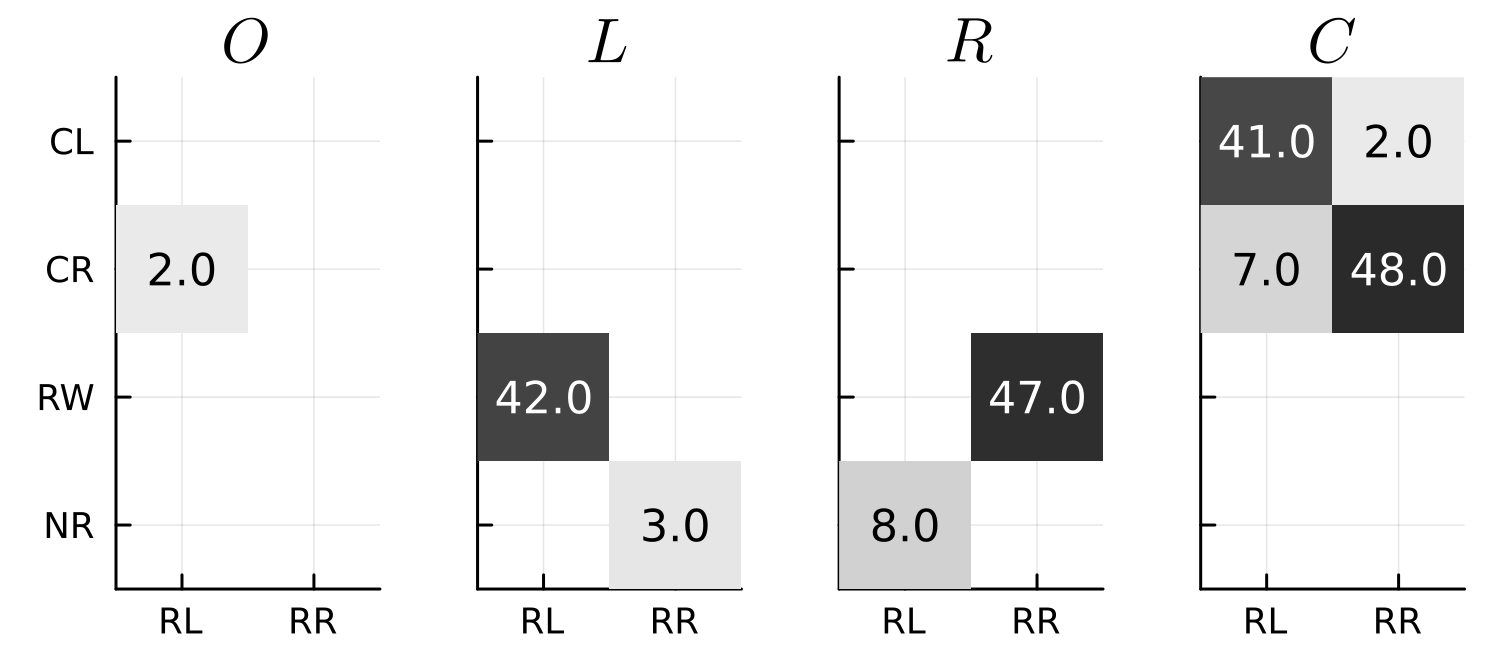

"c:\\Users\\andre\\.cursor-tutor-2\\julia_actinf_pomdp\\scripts\\GFE_A.png"

In [15]:
#include("visualizations.jl")
display(plotObservationStatistics(As[S], A_0))
savefig("GFE_A")     # savefig("figures/GFE_A.png")

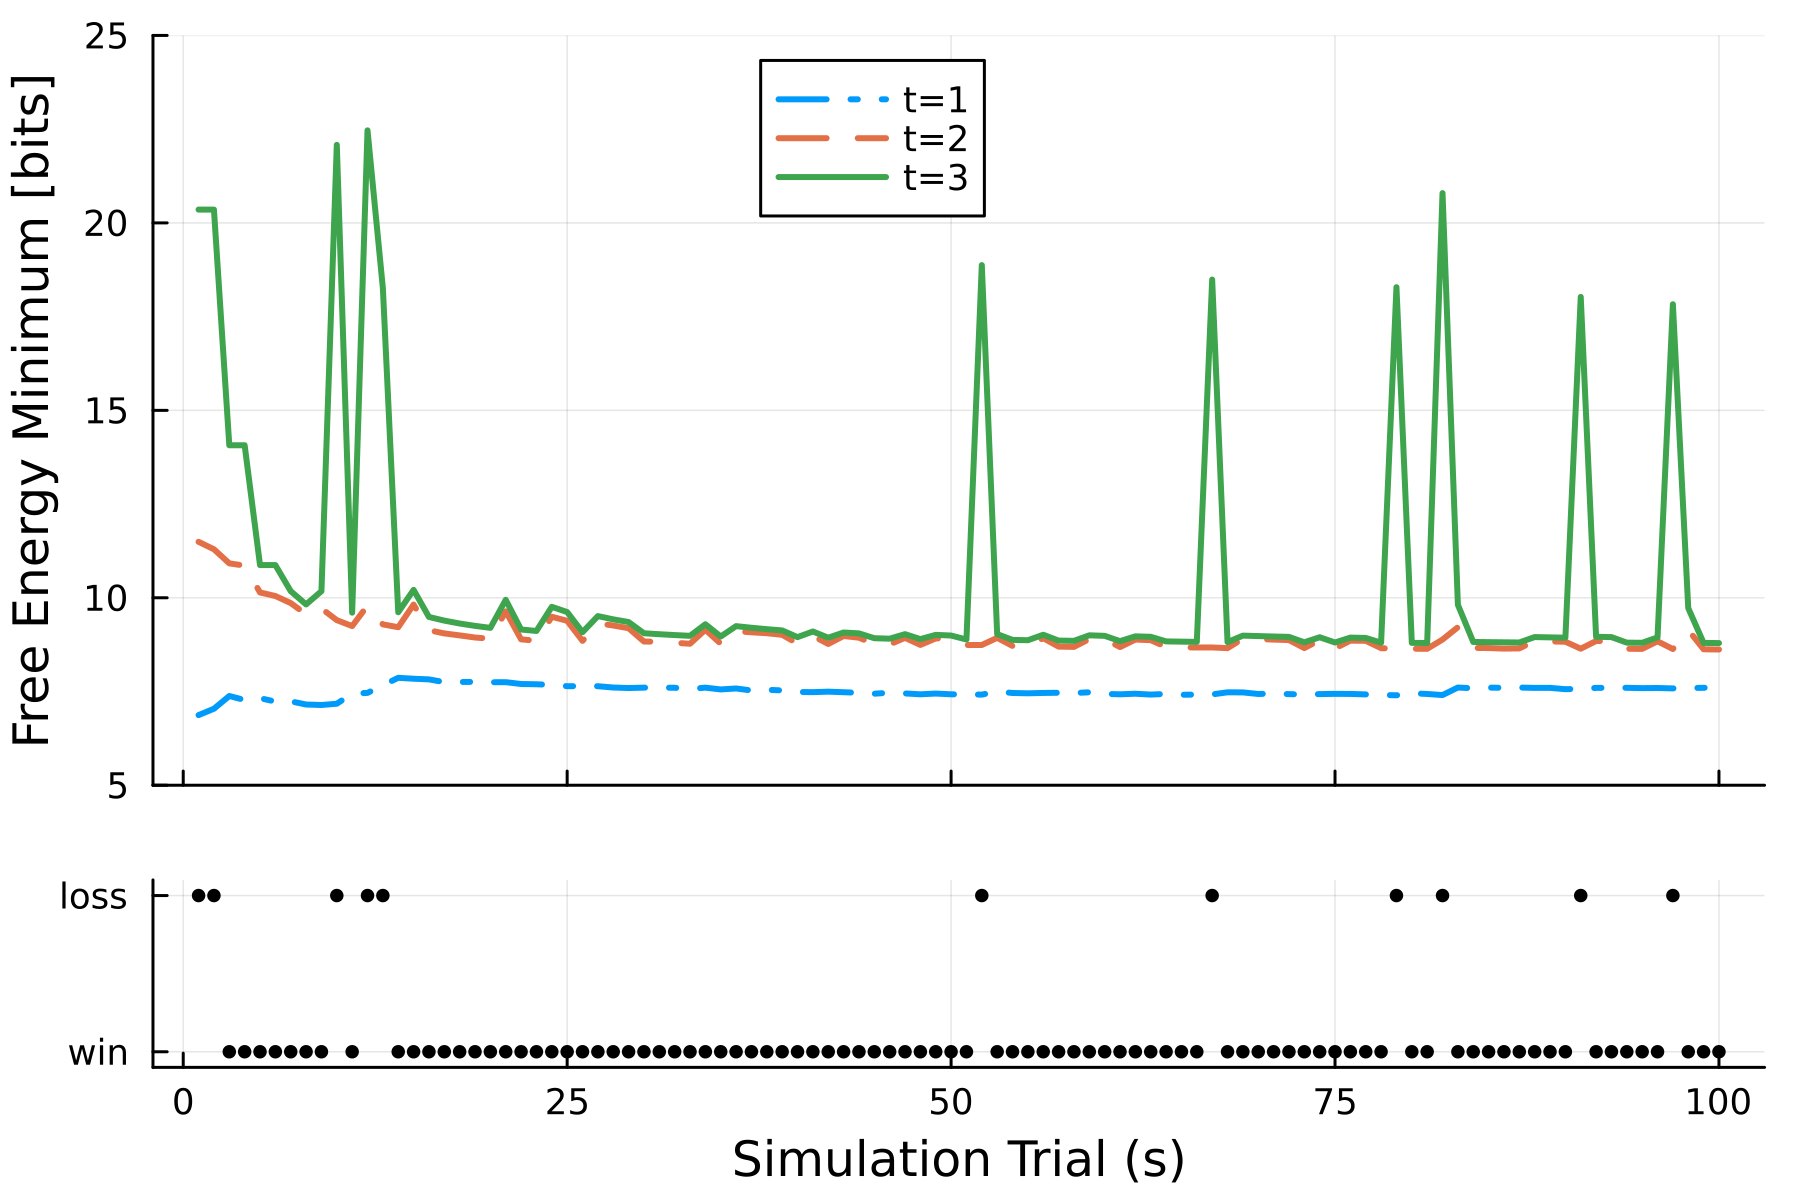

"c:\\Users\\andre\\.cursor-tutor-2\\julia_actinf_pomdp\\scripts\\GFE_FE.png"

In [16]:
#include("visualizations.jl")
display(plotFreeEnergyMinimum(Gs, os, legend=100, ylim=(5,25)))
savefig("GFE_FE.png")     # savefig("figures/GFE_FE.png")
#display("GFE_FE.png", img_base64)